### Fine Tip Clearance Test Objective


### Procedure
- Ensure the drone is positioned on the tester rails such that the fishing line is slack
- Fix the current limit of the DC power supply connected in parallel with the lead acid battery to the same value for all tests. This should be a value between 2 and 8 amps, since the supply is fused at 10A
- Initiate sweep from 30-100% throttle in increments of 10%, holding each throttle for 10 seconds.
- At each throttle step, allow ~2s for transient behaviour to settle and then average over the remaining data (~250 samples) to produce a single DC measurement for thrust, power, rpm, etc. at each point in the sweep.
- Repeat experiment at least once for each aerodynamic configuration, disassembling and reassembling between tests to ensure repeatability.

### Coarse Tip Clearance Test Configurations
| Static Tip Clearance | Clearance to Height Ratio (%) |
|-                     |-                              |
| 1.0 mm               | 14.3 %                        |
| 0.9 mm               | 12.9 %                        |
| 0.8 mm               | 11.4 %                        |
| 0.7 mm               | 10.0 %                        |
| 0.6 mm               | 8.57 %                        |
| 0.5 mm               | 7.14 %                        |
| 0.4 mm               | 5.71 %                        |
| 0.3 mm               | 4.29 %                        |
| 0.2 mm               | 2.86 %                        |
| 0.1 mm               | 1.43 %                        |

### Hypothesis
- As tip clearance decreases, we expect thrust to electrical power efficiency (kgf/W) to increase.

In [16]:
from runner import test_run, TestPlan, TestStep
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Specify Test Plan
Initialize a test plan object which sweeps from 30 to 100% throttle in increments of 10%, holding at each step for 10 seconds

In [19]:
# 1. Create a test plan consisting of steps.
step_duration_ms = 10_000
step_range = np.arange(30, 101, 10)

steps = [
    TestStep(bottom_throttle=i, top_throttle=i, duration_ms=step_duration_ms)
    for i in step_range
]
plan = TestPlan("test", steps=steps)

plan

TestPlan(name='test', steps=[TestStep(duration_ms=10000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=50, bottom_throttle=50, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=60, bottom_throttle=60, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=70, bottom_throttle=70, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=80, bottom_throttle=80, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=90, bottom_throttle=90, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=100, bottom_throttle=100, pitch_angle=None, roll_angle=None)])

In [20]:
print(plan)

TestPlan(name='test', steps=[TestStep(duration_ms=10000, top_throttle=30, bottom_throttle=30, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=40, bottom_throttle=40, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=50, bottom_throttle=50, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=60, bottom_throttle=60, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=70, bottom_throttle=70, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=80, bottom_throttle=80, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=90, bottom_throttle=90, pitch_angle=None, roll_angle=None), TestStep(duration_ms=10000, top_throttle=100, bottom_throttle=100, pitch_angle=None, roll_angle=None)])


### Execute Tests

In [21]:
# Initialize short thrust test to validate propeller mounting direction after changing props
test_duration_ms = 2000
mount_test_throttle = 10
perform_mounting_test = True

mount_test_plan = TestPlan("test", steps=[TestStep(bottom_throttle=mount_test_throttle, top_throttle=mount_test_throttle, duration_ms=test_duration_ms)])

In [23]:
### Execute optional mounting test
if (perform_mounting_test):
    try:
        test_run(filename=None, plan=mount_test_plan)
    except Exception as e:
        print(e)

could not open port 'COM9': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)


In [24]:
test_directory = Path("../test_data/fine_tip_clearance/")

In [25]:
data_dict = {}
data_dict["1mm Fine Tip Clearance - Lead Acid Battery"] = test_run(
    filename=test_directory / "test_1mm_pb_0.csv", plan=plan
)

Loading saved data


### Data Analysis

In [26]:
# Aggregate test data
df_all = pd.concat(data_dict, names=["test_name"])
df_all

top_motor_rpm  \
test_name                                  time_ms                    
1mm Fine Tip Clearance - Lead Acid Battery 0.488                0.0   
                                           5.166                0.0   
                                           9.179                0.0   
                                           13.157               0.0   
                                           17.179               0.0   
...                                                             ...   
                                           41965.161         1228.0   
                                           41969.169         1200.0   
                                           41973.161         1171.0   
                                           41977.169         1114.0   
                                           41981.155         1085.0   

                                                      bottom_motor_rpm  \
test_name                                  time_ms                       
1mm Fine Tip Clearance - Lead Acid Battery 0.488                   0.0   
                                           5.166                   0.0   
                                           9.179                   0.0   
                                           13.157                  0.0   
                                           17.179                  0.0   
...                                                                ...   
                                           41965.161            1242.0   
                                           41969.169            1200.0   
                                           41973.161            1114.0   
                                           41977.169            1128.0   
                                           41981.155            1028.0   

                                                      batt_voltage_V  \
test_name                                  time_ms                     
1mm Fine Tip Clearance - Lead Acid Battery 0.488              14.469   
                                           5.166              13.860   
                                           9.179              13.650   
                                           13.157             13.566   
                                           17.179             13.503   
...                                                              ...   
                                           41965.161          12.075   
                                           41969.169          12.096   
                                           41973.161          12.096   
                                           41977.169          12.096   
                                           41981.155          12.075   

                                                      batt_current_A  \
test_name                                  time_ms                     
1mm Fine Tip Clearance - Lead Acid Battery 0.488               10.24   
                                           5.166               10.24   
                                           9.179               10.24   
                                           13.157              10.24   
                                           17.179              10.24   
...                                                              ...   
                                           41965.161           10.24   
                                           41969.169           10.24   
                                           41973.161           10.24   
                                           41977.169           10.24   
                                           41981.155           10.24   

                                                      top_current_A  \
test_name                                  time_ms                    
1mm Fine Tip Clearance - Lead Acid Battery 0.488           -2.02106   
                                           5.166           -1.78842   
         

In [27]:
# Generate buckets for averaging based on step duration defined in testing
transient_offset_ms = (
    2000  # Ignore first 500 ms of each throttle step to allow transients to settle
)
stable_step_duration_ms = step_duration_ms - transient_offset_ms
step_start_times = np.arange(len(step_range)) * step_duration_ms


# Aggregate data for each throttle step
df_steps = (
    pd.concat(
        [
            df_all.loc[
                (
                    slice(None),
                    slice(
                        t_start + transient_offset_ms,
                        t_start + transient_offset_ms + stable_step_duration_ms,
                    ),
                ),
                :,
            ]
            for t_start in step_start_times
        ],
        keys=step_range,
        names=["throttle"],
    )
    .groupby(["test_name", "throttle"])
    .agg(["mean", "std"])
)

df_steps

top_motor_rpm  \
                                                             mean   
test_name                                  throttle                 
1mm Fine Tip Clearance - Lead Acid Battery 30           4097.0765   
                                           40           8323.1100   
                                           50          11708.0475   
                                           60          14347.7160   

                                                                  \
                                                             std   
test_name                                  throttle                
1mm Fine Tip Clearance - Lead Acid Battery 30        1136.707818   
                                           40         832.753926   
                                           50         669.118143   
                                           60         717.201362   

                                                    bottom_motor_rpm  \
                                                                mean   
test_name                                  throttle                    
1mm Fine Tip Clearance - Lead Acid Battery 30              4155.0690   
                                           40              8592.0195   
                                           50             12086.4120   
                                           60             14961.3015   

                                                                  \
                                                             std   
test_name                                  throttle                
1mm Fine Tip Clearance - Lead Acid Battery 30        1175.978630   
                                           40         877.710699   
                                           50         682.827226   
                                           60         653.652980   

                                                    batt_voltage_V            \
                                                              mean       std   
test_name                                  throttle                            
1mm Fine Tip Clearance - Lead Acid Battery 30            13.311490  0.166385   
                                           40            12.446322  0.133671   
                                           50            11.717969  0.216622   
                                           60            10.933282  0.159112   

                                                    batt_current_A            \
                                                              mean       std   
test_name                                  throttle                            
1mm Fine Tip Clearance - Lead Acid Battery 30             10.24000  0.000000   
                                           40             10.24372  0.089298   
                                           50             15.44916  3.058625   
                                           60             30.04232  3.859051   

                                                    top_current_A            \
                                                             mean       std   
test_name                                  throttle                           
1mm Fine Tip Clearance - Lead Acid Battery 30           -1.237819  0.702124   
                                           40            0.944031  2.035109   
                                           50            6.613737  2.916224   
                                           60           14.165326  2.510432   

                                                    bottom_current_A  \
                                                                mean   
test_name                                  throttle                    
1mm Fine Tip Clearance - Lead Acid Battery 30              -1.537646   
                                           40               1.440888   
                                           50               7.189098   
 

ValueError: could not broadcast input array from shape (8,) into shape (4,)

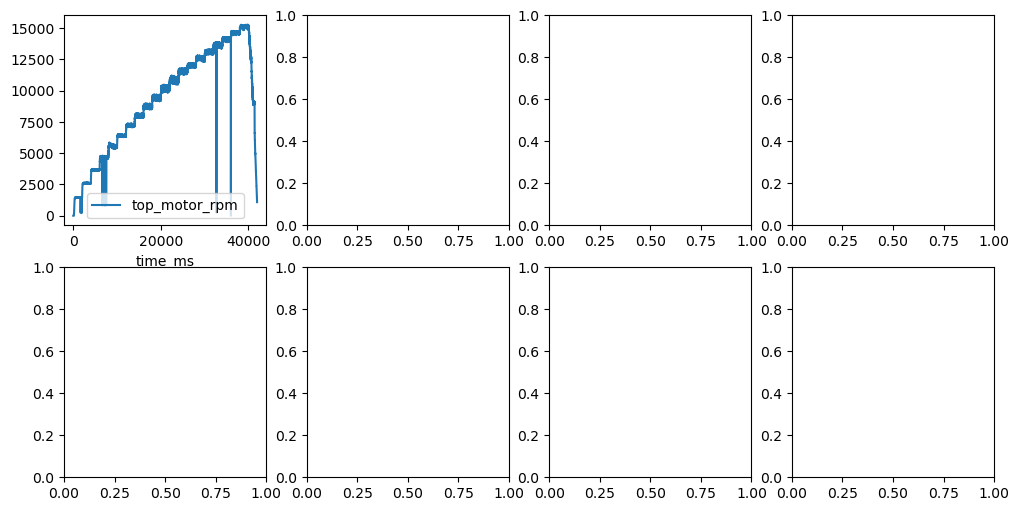

In [28]:
# Debug plots
fig = plt.figure(figsize=(12, 6*len(data_dict)))
subfigs = fig.subfigures(len(data_dict), 1)
if not isinstance(subfigs, np.ndarray):
    subfigs = np.array([subfigs])
for subfig, (n, grp) in zip(subfigs, df_all.groupby("test_name")):
    axs = subfig.subplots(2, 4)
    for ax, col in zip(axs.flat, grp):
        grp.reset_index("test_name").plot(ax=ax, y=col)
        ax.hlines(
            df_steps[col].loc[n]["mean"],
            step_start_times + transient_offset_ms,
            step_start_times + transient_offset_ms + stable_step_duration_ms,
            colors="C1",
            label="Averages",
        )
        ax.legend()
    subfig.suptitle(n)

In [12]:
thrust_mean_g = df_steps["thrust_N"]["mean"] / 9.81 * 1e3
thrust_g_err = df_steps["thrust_N"]["std"] / 9.81 * 1e3

hall_current_mean = df_steps["top_current_A"]["mean"] + df_steps["bottom_current_A"]["mean"]
hall_current_rel_err = (0.02294 * hall_current_mean + 0.3734) / hall_current_mean

batt_voltage_mean = df_steps["batt_voltage_V"]["mean"]
batt_voltage_rel_err = 0.025 / 14.8

shunt_current_mean = df_steps["batt_current_A"]["mean"]
shunt_power_mean = shunt_current_mean * batt_voltage_mean

batt_power_mean = hall_current_mean * batt_voltage_mean
batt_power_rel_err = np.sqrt(hall_current_rel_err**2 + batt_voltage_rel_err**2)

thrust_power_rel_err = np.sqrt((thrust_g_err / thrust_mean_g)**2 + batt_power_rel_err**2)
thrust_mean_g = thrust_mean_g * (thrust_mean_g > 0)

rpm_avg = 0.5*(df_steps["top_motor_rpm"]["mean"] + df_steps["bottom_motor_rpm"]["mean"])

df_thrust_power = pd.DataFrame(
    {
        "rpm_avg": rpm_avg,
        "thrust_mean_g": thrust_mean_g,
        "batt_power_mean": batt_power_mean,
        "shunt_power_mean": shunt_power_mean,
        "thrust_power_g_W": thrust_mean_g / batt_power_mean,
        "shunt_thrust_power_g_W": thrust_mean_g / shunt_power_mean,
        "batt_power_err": np.abs(batt_power_rel_err * batt_power_mean),
        "thrust_g_err": thrust_g_err,
        "thrust_power_err": thrust_power_rel_err * (thrust_mean_g / batt_power_mean)
    }
)

In [13]:
# Set nominal required thrust constants. Used as a benchmark to define region of interest for our data.
hover_thrust_g = 750
payload_thrust_g = 1200

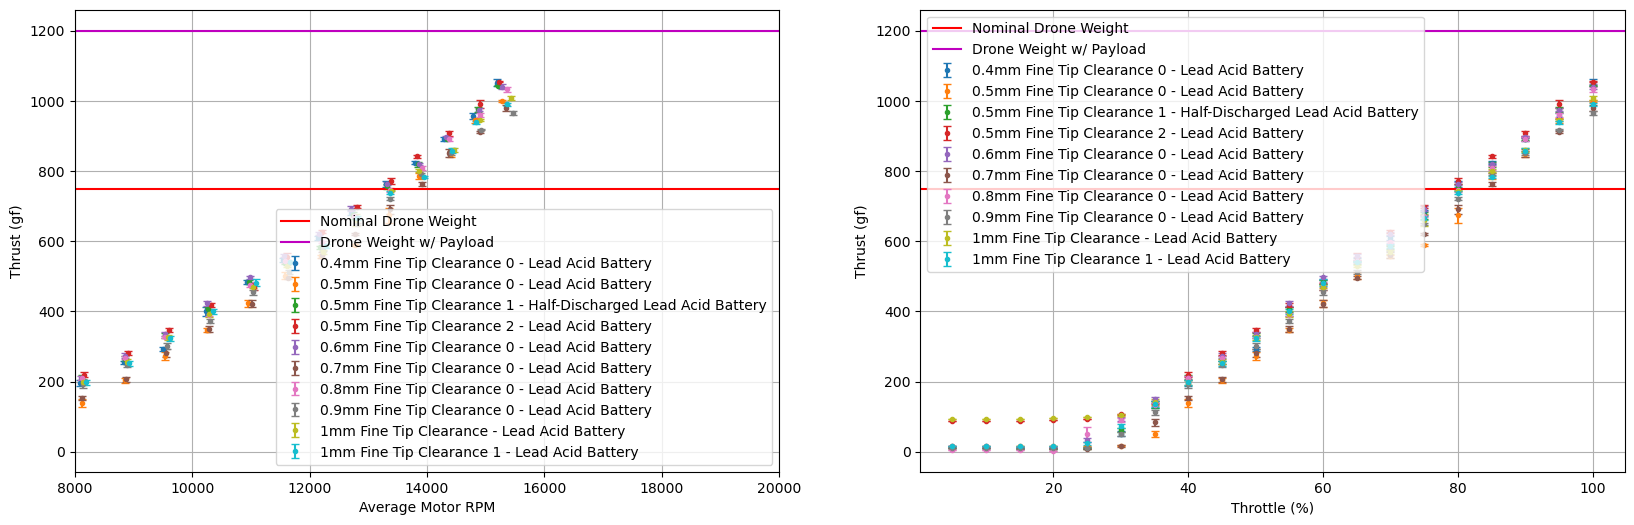

In [15]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    ax[0].errorbar(x="rpm_avg", y="thrust_mean_g", yerr="thrust_g_err", data=grp, label=n, fmt='o', capsize=3, markersize=3)
    ax[1].errorbar(x=grp.index.get_level_values("throttle"), y="thrust_mean_g", yerr="thrust_g_err", data=grp, label=n, fmt='o', capsize=3, markersize=3)

ax[0].set_xlabel("Average Motor RPM")
ax[0].set_ylabel("Thrust (gf)")
ax[0].set_xlim(8000, 20000)
ax[0].axhline(hover_thrust_g, color="r", label="Nominal Drone Weight")
ax[0].axhline(payload_thrust_g, color="m", label="Drone Weight w/ Payload")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("Throttle (%)")
ax[1].set_ylabel("Thrust (gf)")
ax[1].axhline(hover_thrust_g, color="r", label="Nominal Drone Weight")
ax[1].axhline(payload_thrust_g, color="m", label="Drone Weight w/ Payload")
ax[1].legend()
ax[1].grid()

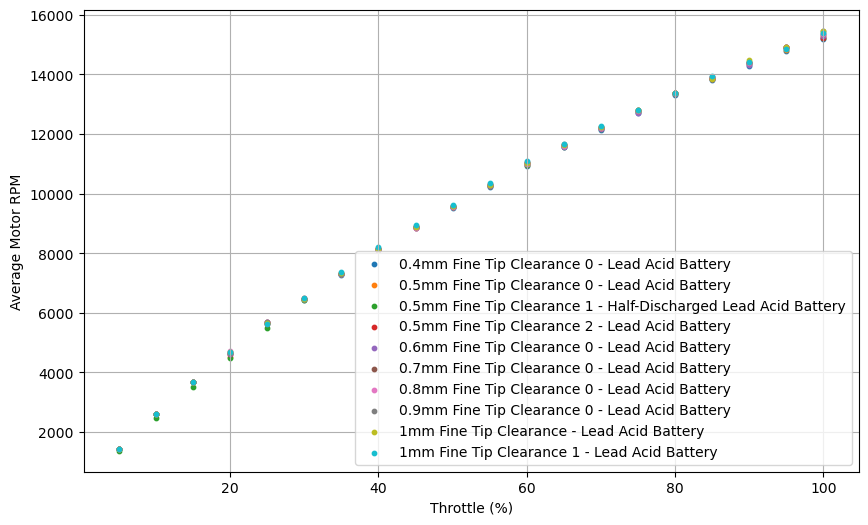

In [16]:
plt.figure(figsize=(10, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x=grp.index.get_level_values("throttle"), y="rpm_avg", data=grp, label=n, s=10)
plt.xlabel("Throttle (%)")
plt.ylabel("Average Motor RPM")
plt.legend()
plt.grid()
plt.show()

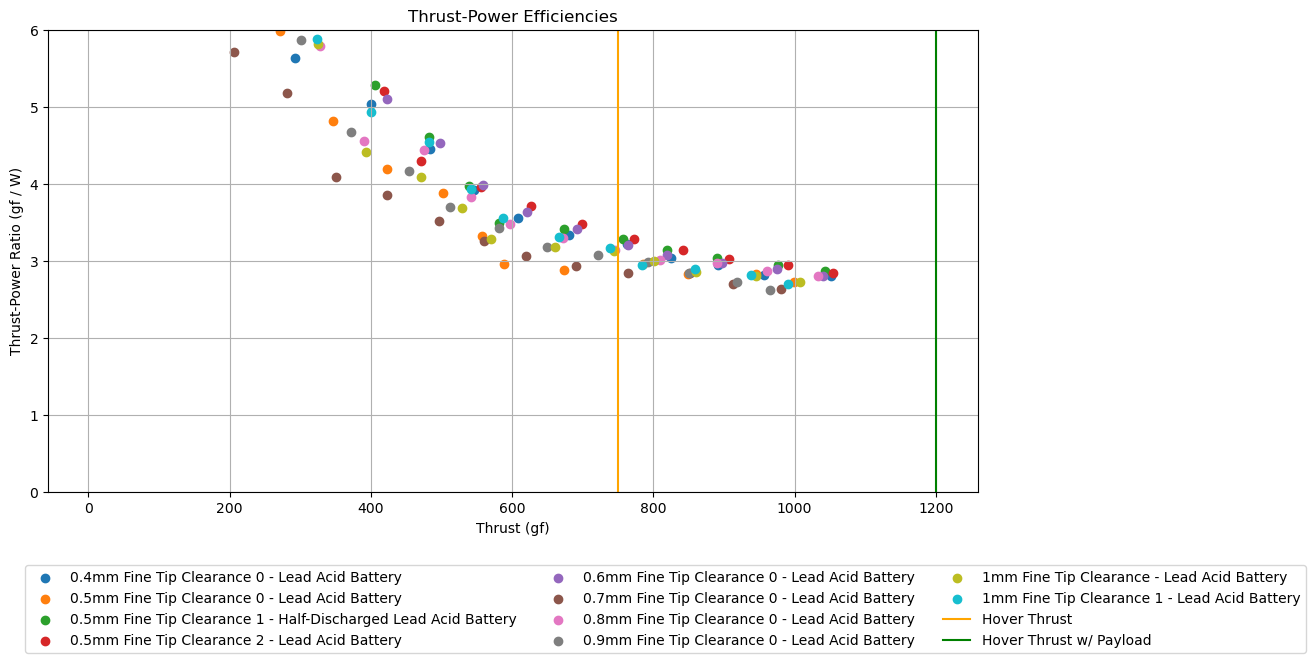

In [17]:
fig = plt.figure(figsize=(12, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="thrust_power_g_W", data=grp, label=n)
plt.xlabel("Thrust (gf)")
plt.ylabel("Thrust-Power Ratio (gf / W)")
# plt.xlim(400, 1750)
plt.ylim(0,6)
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.grid()
plt.legend(ncols=3, bbox_transform=fig.transFigure, bbox_to_anchor=(0.1, 0), loc="upper left")
plt.title("Thrust-Power Efficiencies")
plt.show()

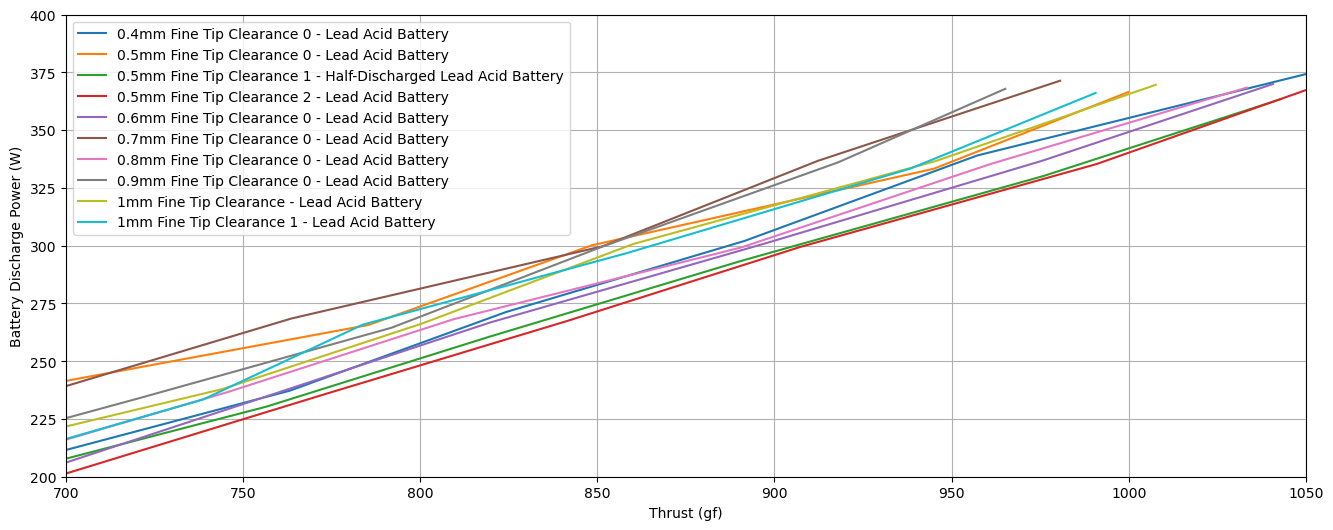

In [31]:
plt.figure(figsize=(16, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="thrust_mean_g", y="batt_power_mean", data=grp, label=n, s=10)
plt.xlabel("Thrust (gf)")
plt.ylabel("Battery Discharge Power (W)")
plt.xlim(700, 1200)
plt.ylim(200, 400)
plt.grid()
plt.axvline(hover_thrust_g, color="orange", label="Hover Thrust")
plt.axvline(payload_thrust_g, color="g", label="Hover Thrust w/ Payload")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(16, 6))
for n, grp in df_thrust_power.groupby("test_name"):
    plt.scatter(x="rpm_avg", y="batt_power_mean", label=n, data=grp)
plt.xlabel("RPM")
plt.ylabel("Battery Discharge Power (W)")
plt.grid()
plt.legend()
plt.show()